In [1]:
import pandas as pd
import numpy as np
from random import sample
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
import glob
import cv2

#from google.colab import drive

import matplotlib.pyplot as plt
import keras as ks
from keras import layers
from keras.models import Sequential
import tensorflow as tf
from keras.backend import categorical_crossentropy

import os

from keras.applications.inception_v3 import preprocess_input
from keras.models import Sequential
from keras.models import Model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
from keras import optimizers, losses, activations, models
from keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Concatenate
from keras import applications
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import SGD

In [2]:
#drive.mount('/content/drive')

In [2]:
image_size = (120, 120)
batch_size = 32


train_directory = 'Training_cropped'
val_directory = 'Valid_cropped'
test_directory = 'Test_cropped'

train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_directory, label_mode='categorical', image_size=image_size, batch_size=batch_size)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(val_directory, label_mode='categorical', image_size=image_size, batch_size=batch_size)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(test_directory, label_mode='categorical', image_size=image_size, batch_size=batch_size)

train_ds = train_ds.prefetch(buffer_size=batch_size)
val_ds = val_ds.prefetch(buffer_size=batch_size)
test_ds = test_ds.prefetch(buffer_size=batch_size)

Found 25000 files belonging to 5 classes.
Found 27427 files belonging to 5 classes.
Found 34281 files belonging to 5 classes.


In [3]:
input_shape = (120, 120)
nclass = 5

# create the base pre-trained model 
base_model = InceptionV3(weights='imagenet', 
                                include_top=False, 
                                input_shape= (input_shape+(3,)))

# to freeze the base model 
# https://keras.io/guides/transfer_learning/
#base_model.trainable = False

# to add layers to the model 
add_model = Sequential()
add_model.add(base_model)
add_model.add(layers.Rescaling(1.0/255))
add_model.add(layers.Conv2D(32, 3, strides=2, padding='same'))
add_model.add(layers.BatchNormalization())
add_model.add(layers.Activation('relu'))
add_model.add(layers.Conv2D(64, 3, strides=2, padding='same'))
add_model.add(layers.BatchNormalization())
add_model.add(layers.Activation('relu'))
add_model.add(GlobalAveragePooling2D()) # to add a global spatial average pooling layer 
add_model.add(Dropout(0.5))
add_model.add(Dense(nclass, activation='softmax')) #there are 5 classes 

# compile the model (should be done *after* setting layers to non-trainable)
model = add_model
model.compile(optimizer='adam', loss='CategoricalCrossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 rescaling (Rescaling)       (None, 2, 2, 2048)        0         
                                                                 
 conv2d_94 (Conv2D)          (None, 1, 1, 32)          589856    
                                                                 
 batch_normalization_94 (Bat  (None, 1, 1, 32)         128       
 chNormalization)                                                
                                                                 
 activation_94 (Activation)  (None, 1, 1, 32)          0         
                                                                 
 conv2d_95 (Conv2D)          (None, 1, 1, 64)          18496     
                                                        

In [5]:
file_path="inceptionv3_5C5K_CROPPED_{epoch}.h5"

epochs = 1000

callbacks = [ks.callbacks.ModelCheckpoint(file_path, save_best_only=True), 
             ks.callbacks.EarlyStopping(patience=20, restore_best_weights=True)]

history = model.fit(train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds)

Epoch 1/1000
782/782 [==============================] - 888s 1s/step - loss: 1.2440 - accuracy: 0.5156 - val_loss: 2.3543 - val_accuracy: 0.2756
Epoch 2/1000
782/782 [==============================] - 864s 1s/step - loss: 1.0933 - accuracy: 0.5759 - val_loss: 1.6151 - val_accuracy: 0.3778
Epoch 3/1000
782/782 [==============================] - 873s 1s/step - loss: 0.9731 - accuracy: 0.6319 - val_loss: 1.4967 - val_accuracy: 0.5520
Epoch 4/1000
782/782 [==============================] - 858s 1s/step - loss: 0.9291 - accuracy: 0.6496 - val_loss: 6.0087 - val_accuracy: 0.2319
Epoch 5/1000
782/782 [==============================] - 850s 1s/step - loss: 0.8331 - accuracy: 0.6992 - val_loss: 1.0692 - val_accuracy: 0.6374
Epoch 6/1000
782/782 [==============================] - 863s 1s/step - loss: 0.8201 - accuracy: 0.7028 - val_loss: 23.1702 - val_accuracy: 0.4525
Epoch 7/1000
782/782 [==============================] - 877s 1s/step - loss: 0.9637 - accuracy: 0.6358 - val_loss: 1.1890 - val_a

In [4]:
model = ks.models.load_model('inceptionv3_5C5K_CROPPED_18.h5')

In [5]:
true = []
pred = []
batches = int(np.ceil(34281/32))
i = 1
for image, label in test_ds:
  pred = np.concatenate([pred, 
                         np.argmax(model.predict(image), axis=-1)])
  true = np.concatenate([true,
                         np.argmax(label.numpy(), axis=-1)])
  print('{}/{}'.format(i, batches))
  i += 1

1/1072
2/1072
3/1072
4/1072
5/1072
6/1072
7/1072
8/1072
9/1072
10/1072
11/1072
12/1072
13/1072
14/1072
15/1072
16/1072
17/1072
18/1072
19/1072
20/1072
21/1072
22/1072
23/1072
24/1072
25/1072
26/1072
27/1072
28/1072
29/1072
30/1072
31/1072
32/1072
33/1072
34/1072
35/1072
36/1072
37/1072
38/1072
39/1072
40/1072
41/1072
42/1072
43/1072
44/1072
45/1072
46/1072
47/1072
48/1072
49/1072
50/1072
51/1072
52/1072
53/1072
54/1072
55/1072
56/1072
57/1072
58/1072
59/1072
60/1072
61/1072
62/1072
63/1072
64/1072
65/1072
66/1072
67/1072
68/1072
69/1072
70/1072
71/1072
72/1072
73/1072
74/1072
75/1072
76/1072
77/1072
78/1072
79/1072
80/1072
81/1072
82/1072
83/1072
84/1072
85/1072
86/1072
87/1072
88/1072
89/1072
90/1072
91/1072
92/1072
93/1072
94/1072
95/1072
96/1072
97/1072
98/1072
99/1072
100/1072
101/1072
102/1072
103/1072
104/1072
105/1072
106/1072
107/1072
108/1072
109/1072
110/1072
111/1072
112/1072
113/1072
114/1072
115/1072
116/1072
117/1072
118/1072
119/1072
120/1072
121/1072
122/1072
123/1072
1

924/1072
925/1072
926/1072
927/1072
928/1072
929/1072
930/1072
931/1072
932/1072
933/1072
934/1072
935/1072
936/1072
937/1072
938/1072
939/1072
940/1072
941/1072
942/1072
943/1072
944/1072
945/1072
946/1072
947/1072
948/1072
949/1072
950/1072
951/1072
952/1072
953/1072
954/1072
955/1072
956/1072
957/1072
958/1072
959/1072
960/1072
961/1072
962/1072
963/1072
964/1072
965/1072
966/1072
967/1072
968/1072
969/1072
970/1072
971/1072
972/1072
973/1072
974/1072
975/1072
976/1072
977/1072
978/1072
979/1072
980/1072
981/1072
982/1072
983/1072
984/1072
985/1072
986/1072
987/1072
988/1072
989/1072
990/1072
991/1072
992/1072
993/1072
994/1072
995/1072
996/1072
997/1072
998/1072
999/1072
1000/1072
1001/1072
1002/1072
1003/1072
1004/1072
1005/1072
1006/1072
1007/1072
1008/1072
1009/1072
1010/1072
1011/1072
1012/1072
1013/1072
1014/1072
1015/1072
1016/1072
1017/1072
1018/1072
1019/1072
1020/1072
1021/1072
1022/1072
1023/1072
1024/1072
1025/1072
1026/1072
1027/1072
1028/1072
1029/1072
1030/1072
1031/1

In [6]:
from sklearn.metrics import accuracy_score
accuracy_score(true, pred)

0.6881946267611797

In [8]:
model_results = pd.DataFrame({'true':true,
                              'pred':pred})

model_results.to_csv('inceptionv3_v3_CROPPED_ST_test_preds.csv')

In [9]:
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(true, pred)

0.5915326988772117

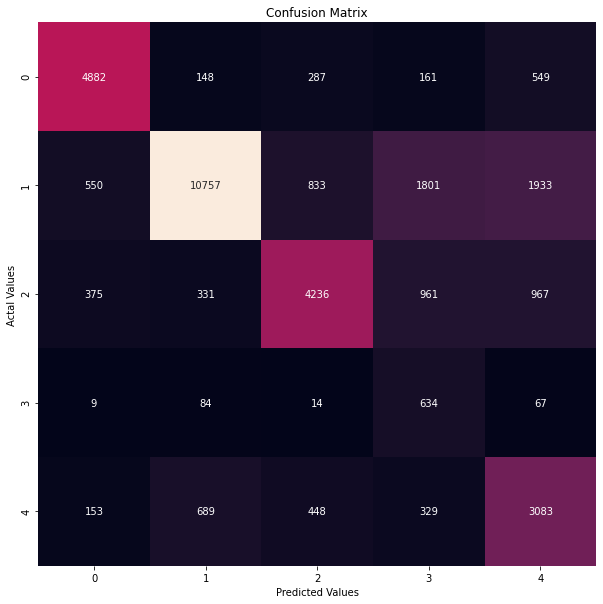

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(true, pred)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt = '.0f', cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [23]:
from sklearn.metrics import classification_report
print(classification_report(true, pred))

              precision    recall  f1-score   support

         0.0       0.82      0.81      0.81      6027
         1.0       0.90      0.68      0.77     15874
         2.0       0.73      0.62      0.67      6870
         3.0       0.16      0.78      0.27       808
         4.0       0.47      0.66      0.55      4702

    accuracy                           0.69     34281
   macro avg       0.61      0.71      0.61     34281
weighted avg       0.77      0.69      0.72     34281

